# LSTM Attempt 1 - Akira

In [ ]:
import re
import os
import time
import random
import numpy as np
import pandas as pd
import torch
import spacy
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from collections import Counter
import pickle
import matplotlib.pyplot as plt
import math
from google.colab import drive

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [ ]:
with open('./train.pkl', 'rb') as f:
    train = pickle.load(f)

In [ ]:
def create_train_test_loaders(df, embedding_type, batch_size=600, test_ratio=0.9):
  max_row=96562
  if embedding_type=="tfidf":
    embedding=np.array([r.toarray() for r in train["tfidf"].values[:max_row]]).reshape((max_row, 100))
  elif embedding_type=="glove":
    embedding=np.array([np.array(r)[:-1] for r in train["glove"].values[:max_row]])
  elif embedding_type=="bert":
    embedding=np.array([np.array(r) for r in train["bert"].values[:max_row]])
  elif embedding_type=="d2v":
    embedding=np.array([np.array(r) for r in train["d2v"].values[:max_row]])
  elif embedding_type=="use":
    embedding=np.array([np.array(r) for r in train["use"].values[:max_row]]).reshape((max_row, 512))
  elif embedding_type=="cv":
    embedding=np.array([r.toarray() for r in train["cv"].values[:max_row]]).reshape((max_row, 100))
  else:
    print("embedding type not supported")
    return -1

  test_index=int(max_row*test_ratio)
  at_count=np.array(df["@_count"].values[:max_row]).reshape((-1,1))
  hash_count=np.array(df["#_count"].values[:max_row]).reshape((-1,1))
  year=np.array(df["year"].values[:max_row]).reshape((-1,1))
  month=np.array(df["month"].values[:max_row]).reshape((-1,1))
  week_day=np.array(df["week_day"].values[:max_row]).reshape((-1,1))
  hour=np.array(df["hour"].values[:max_row]).reshape((-1,1))
  #is_reply_to_tweet=np.array(df["is_reply_to_tweet"].values[:max_row]).reshape((-1,1))
  #is_reply_to_user=np.array(df["is_reply_to_user"].values[:max_row]).reshape((-1,1))
  
  so_far=np.array(df["user_total_retweeted_so_far"].values[:max_row]).reshape((-1,1))

  
  #user_id=np.array(df["user_id"].values[:max_row]).reshape((-1,1))
  url_count=np.array(df["url_count"].values[:max_row]).reshape((-1,1))
  labels=np.array(df["retweet_count"].values[:max_row]).reshape((-1,1)).astype(np.float32)
  features=np.hstack(( embedding, at_count, hash_count, year, month, week_day, hour, url_count, so_far)).astype(np.float32)
  print(np.max(labels))
  #np.random.shuffle(features)
  #labels=features[:,:1]
  #features=features[:,1:]
  #features=features.reshape((features.shape[0],1,features.shape[1]))

  train_data = TensorDataset(torch.from_numpy(features[:test_index]), torch.from_numpy(labels[:test_index]))
  test_data = TensorDataset(torch.from_numpy(features[test_index:]), torch.from_numpy(labels[test_index:]))
  print(features)
  train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
  test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

  return train_loader, test_loader, features.shape[1]


In [ ]:
class Retweet_Net(nn.Module):
    def __init__(self, feature_num, hidden_units=512):
        super().__init__()
        self.feature_num = feature_num
        self.hidden_units = hidden_units
        self.num_layers = 2

        self.lstm = nn.LSTM(
            input_size=feature_num,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers,
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        #self.lstm.flatten_parameters()
        #_, (hidden, _) = self.lstm(x)
        #out = hidden[-1]
        batch_size = x.shape[1]
        h0 = torch.zeros(self.num_layers, self.hidden_units).requires_grad_().cuda()
        c0 = torch.zeros(self.num_layers, self.hidden_units).requires_grad_().cuda()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()

        return nn.functional.relu(out)

In [ ]:
def train_model(data_loader, model, loss_function, optimizer, batch_size=600, epochs=10):
    for e in range(epochs):
        print("Epoch: "+str(e+1)+"/"+str(epochs))
        num_batches = len(data_loader)
        total_loss = []
        num_of_exception_loss=0
        total_out=[]
        total_y=[]
        max_loss=0
        for index, (X, y) in enumerate(data_loader):
            model.train()
            X=X.cuda()
            y=y.cuda()
            output = model(X)
            loss = loss_function(output, y)
            
            if index%2000==0:
              print(index)
              print(output)
              print(y)
              print(loss)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss.append(loss.item())
            total_y.append(np.mean(y.cpu().detach().numpy().T))
            if loss.item()>10000:
              #total_loss.pop()
              num_of_exception_loss+=1
            total_out.append(output.item())
            

        plt.scatter(list(range(len(total_loss))), total_loss)
        plt.show()
        plt.scatter(list(range(len(total_out))), total_out)
        plt.show()
        plt.scatter(list(range(len(total_y))), total_y)
        plt.show()
        avg_loss = sum(total_loss) / len(total_loss)
        print(f"Train loss: {avg_loss}", "exception: "+str(num_of_exception_loss))

In [ ]:
def test_model(data_loader, model, loss_function1):
    loss_function = nn.MSELoss()
    num_batches = len(data_loader)
    total_loss = []
    num_of_exception_loss=0
    total_out=[]
    model.eval()
    total_y=[]
    with torch.no_grad():
        for X, y in data_loader:
            X=X.cuda()
            y=y.cuda()
            output = model(X)
            loss=loss_function(output, y)
            total_loss.append(loss.item())
            if loss.item()>10000:
               # total_loss.pop()
                num_of_exception_loss+=1
            total_out.append(output.item())
            total_y.append(np.mean(y.cpu().detach().numpy().T))

    plt.scatter(list(range(len(total_loss))), total_loss)
    plt.show()
    plt.scatter(list(range(len(total_out))), total_out)
    plt.show()
    plt.scatter(list(range(len(total_y))), total_y)
    plt.show()
    avg_loss = sum(total_loss) / len(total_loss)
    print(f"Train loss mse: {avg_loss}", "exception: "+str(num_of_exception_loss))

In [ ]:
#testing with glove embedding first
batch_size=10
train_glove, test_glove, feature_num = create_train_test_loaders(train, "glove", batch_size=batch_size, test_ratio=0.8)
print(len(train_glove))

In [ ]:
model=Retweet_Net(feature_num)
model.cuda()
print(model)

In [ ]:
loss_function = nn.MSELoss()
#loss_function=nn.PoissonNLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [ ]:
train_model(train_glove,model, loss_function, optimizer, batch_size, epochs=1)

In [ ]:
test_model(test_glove, model, loss_function)

# LSTM Attempt 2 - Akira

In [1]:
#ORIGINAL: https://github.com/sagarjinde/Tweet-Popularity-Prediction

# Basic packages
import pandas as pd 
import numpy as np
import re
import os
import collections
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import regex
import math
import random
import json

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import datetime
from dateutil.parser import parse

# Packages for modeling
from keras import models
from keras import optimizers
from keras.models import Model
from keras import layers
from keras.layers import Dense, Embedding, LSTM, Input, SimpleRNN, TimeDistributed, Concatenate, BatchNormalization, LeakyReLU
from keras import regularizers
from keras import backend as K
from keras import regularizers

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zhuyl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 26  # Maximum number of words in a sequence
GLOVE_DIM = 100  # Number of dimensions of the GloVe word embeddings
LSTM_OUT = 256  # output dimension of language model lstm
NORMALIZE_TO = 10  # normalize the value of features between 0 to NORMALIZE_TO
RETWEETS_NORM_TO = 10    # normalize retweet between 0 to RETWEETS_NORM_TO
HOURS = 2  # number of hours the dataset was recorded for
RANDOM_NUM = random.randint(0,100)
retweet_count_hour_path="./retweet_count_"+str(HOURS)+".csv"

In [ ]:
with open("./train.json", 'r') as j:
     train = json.loads(j.read())
        
custom_columns=["tweet_id","text","timestamp","year","month","week_day","hour","is_reply_to_tweet","is_reply_to_user",
            "user_id","@_count","#_count","url_count","tweet_len", "rewteet_count", "favorite_count", 
                'friends_count', 'followers_count', 'account_age', 'total_tweet_count', 'favourited_tweet_count']
features=[]
for i,twt in enumerate(train):
    row=[twt["id_str"], twt["text"]]
    time=parse(twt['created_at'])
    row.extend([int(time.timestamp()), time.year, time.month, time.weekday(), time.hour])
    if twt["in_reply_to_status_id_str"]==None:
        row.append(0)
    else:
        row.append(1)

    if twt["in_reply_to_user_id_str"]==None:
        row.append(0)
    else:
        row.append(1)

    row.append(twt["user"]["id_str"])
    row.append(len(twt["entities"]["user_mentions"]))
    row.append(len(twt["entities"]["hashtags"]))
    row.append(len(twt["entities"]["urls"]))
    row.append(len(twt["text"]))
    row.append(twt["retweet_count"])
    row.append(twt["favorite_count"])
    row.append(twt["user"]["friends_count"])
    row.append(twt["user"]["followers_count"])
    age=2022-parse(twt["user"]['created_at']).year
    row.append(age)
    row.append(twt["user"]["listed_count"])
    row.append(twt["user"]["favourites_count"])

    features.append(row)

feature_df=pd.DataFrame(data=features, columns=custom_columns)
feature_df.to_csv("./processed_X.csv",index=False)

In [17]:
def generate_retweet_count_time_csv(train, hours=72):
    hours=hours+1
    columns_hours=["tweet_id"]+list(range(hours))
    retweet_count=[]
    for i,twt in enumerate(train):
        row=[twt["id_str"]]
        rt_c=twt["retweet_count"]
        if hours>1:
            row.append(0)
            step=rt_c/(hours-1)
            for j in range(1, hours):
                row.append(int(step*j))
        else:
            row.append(rt_c)
        retweet_count.append(row)
    retweet_count_df=pd.DataFrame(data=retweet_count, columns=columns_hours)
    retweet_count_df.to_csv("./retweet_count_"+str(hours-1)+".csv",index=False)
    print("saved "+"retweet_count_"+str(hours-1)+".csv")
    return

#Make sure that hours number matches the HOURS constant or at least a csv of that hours exist
generate_retweet_count_time_csv(train, HOURS)

saved retweet_count_2.csv


In [18]:
#path = os.path.dirname(os.path.realpath(__file__))

"""Tweet text pre-processing"""

FLAGS = re.MULTILINE | re.DOTALL | regex.VERSION1

def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = "<hashtag> {} <allcaps>".format(hashtag_body)
    else:
        result = " ".join(["<hashtag>"] + regex.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps>"


def tokenize(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"#\S+", hashtag)
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    text = re_sub(r"([A-Z]){2,}", allcaps)

    return text.lower()

def deep_model(model, X_train, u_train, a_train, y_train, X_valid, u_valid, a_valid, y_valid):

    train_shape = a_train.shape
    train_shape = list(train_shape)
    train_shape.append(1)

    valid_shape = a_valid.shape
    valid_shape = list(valid_shape)
    valid_shape.append(1)

    history = model.fit([X_train, u_train, a_train.values.reshape(train_shape)]
                       , y_train.values.reshape(train_shape)
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=([X_valid, u_valid, a_valid.values.reshape(valid_shape)]
                                          , y_valid.values.reshape(valid_shape))
                       , verbose=1
                       , shuffle=True)

    return history

def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)

def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

def poisson_loss(y_actual, y_predicted):
    loss = K.exp(y_predicted) - y_actual*y_predicted
    return loss

def save_model(model):
    model.save('./saved_models/final_model.h5')

def get_model():
    model = models.load_model('./saved_models/final_model.h5', custom_objects={'poisson_loss': poisson_loss})
    return model

In [19]:
df = pd.read_csv('./processed_X.csv') 
df = df[['tweet_id', 'text', 'friends_count', 'followers_count', 'account_age', 'total_tweet_count', 'favourited_tweet_count']]      # X, y
df.text = df.text.apply(tokenize).apply(remove_stopwords).apply(remove_mentions)

# find maximum
dg = pd.read_csv(retweet_count_hour_path)
dg = dg[[str(HOURS)]]
max_retweet_count = int(dg.max())
print('MAX RETWEET COUNT: ',max_retweet_count)

# normalize data for hours 0 to 71 (auxilary hours)
hrs = [str(i) for i in range(HOURS)]
dg = pd.read_csv(retweet_count_hour_path)
dg = (dg[hrs]/max_retweet_count)*RETWEETS_NORM_TO
# dg = dg[hrs]

X_train, X_test, a_train, a_test = train_test_split(df.text, dg, test_size=0.1, random_state=RANDOM_NUM)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == a_train.shape[0]
assert X_test.shape[0] == a_test.shape[0]

# normalize data for hours 1 to 72 (output hours)
hrs = [str(i) for i in range(1,HOURS+1)]
dg = pd.read_csv(retweet_count_hour_path)
dg = (dg[hrs]/max_retweet_count)*RETWEETS_NORM_TO
# dg = dg[hrs]

X_train, X_test, y_train, y_test = train_test_split(df.text, dg, test_size=0.1, random_state=RANDOM_NUM)
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# user account features
dh = pd.read_csv('./processed_X.csv') 
user_featuers = ['friends_count', 'followers_count', 'account_age', 'total_tweet_count', 'favourited_tweet_count']

features = []
user_feature_count = len(user_featuers)
for i in range(user_feature_count-1):
    for j in range(i+1,user_feature_count):
        feature = dh[user_featuers[i]]*dh[user_featuers[j]]
        max_feature_value = feature.max()
        feature = (feature/max_feature_value)*NORMALIZE_TO
        features.append(feature)

features_count = len(features)
features = pd.concat(features, axis=1)

X_train, X_test, u_train, u_test = train_test_split(df.text, features, test_size=0.1, random_state=RANDOM_NUM)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == u_train.shape[0]
assert X_test.shape[0] == u_test.shape[0]

seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
tweet_stats = seq_lengths.describe()
MAX_LEN = int(tweet_stats['max'])
print('MAX_LEN: ',MAX_LEN)


tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)      # creates a internal dictionary
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train, test_size=0.1, random_state=RANDOM_NUM)
X_train_emb, X_valid_emb, a_train_emb, a_valid_emb = train_test_split(X_train_seq_trunc, a_train, test_size=0.1, random_state=RANDOM_NUM)
X_train_emb, X_valid_emb, u_train_emb, u_valid_emb = train_test_split(X_train_seq_trunc, u_train, test_size=0.1, random_state=RANDOM_NUM)
assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]
print('Shape of training set:',X_train_emb.shape)
print('Shape of validation set:',X_valid_emb.shape)

MAX RETWEET COUNT:  34655
# Train data samples: 86905
# Test data samples: 9657
# Train data samples: 86905
# Test data samples: 9657
MAX_LEN:  42
Shape of training set: (78214, 42)
Shape of validation set: (8691, 42)


In [20]:
"""Creating a Dictionary"""
print('creating Dictionary...')
glove_file = './glove.twitter.27B.100d.txt'
emb_dict = {}
glove = open(glove_file, encoding="utf8")
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))
for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

creating Dictionary...


In [21]:
"""Building Model"""

# This is for training
encoder_inputs = Input(shape=(MAX_LEN, ), name='input_1')
embedding = Embedding(NB_WORDS, GLOVE_DIM, name='embedding_1')
embedding_inputs = embedding(encoder_inputs)
encoder = LSTM(LSTM_OUT, recurrent_dropout = 0.3, dropout = 0.3, name='lstm_1', kernel_regularizer=regularizers.l2(0.05))
lstm_output = encoder(embedding_inputs)
user_info_inputs = Input(shape=(features_count,), name='input_2')
dense1 = Dense(units=128, name='dense_1', kernel_regularizer=regularizers.l2(0.05))     # Whc
full_info = Concatenate(name='concatenate_1')([lstm_output, user_info_inputs])
encoder_output_dense1 = dense1(full_info)

decoder_inputs = Input(shape=(None, 1), name='input_3')

# dynamic RNN
decoder_rnn = SimpleRNN(128, return_sequences=True, return_state=True, name='rnn_1', kernel_regularizer=regularizers.l2(0.05))
time_distributed = TimeDistributed(Dense(1, activation='linear'), name='time_distributed_1')

# decoder_outputs 
# We are passing encoder_output as the hidden state of dynamic RNN
decoder_outputs, _ = decoder_rnn(decoder_inputs, initial_state=encoder_output_dense1)
decoder_outputs = time_distributed(decoder_outputs)
final_model = Model([encoder_inputs, user_info_inputs, decoder_inputs], decoder_outputs)

# weights of encoder is already there in decoder, hence we dont need to call it saperatly.
# final_model.load_weights(path+'/saved_models/final_model.h5', by_name=True)

# This is what makes model use pre-trained weights
final_model.layers[1].set_weights([emb_matrix])
final_model.layers[1].trainable = False
opt = opt = optimizers.Adam(learning_rate=0.01, clipnorm=1.0)
final_model.compile(optimizer=opt, loss=poisson_loss)
final_model.summary()

print("start train")

glove_history = deep_model(final_model, X_train_emb, u_train_emb, a_train_emb, y_train_emb, X_valid_emb, u_valid_emb, a_valid_emb, y_valid_emb)

save_model(final_model)

with open('./loss_log_total.txt', 'w') as f:
    for key, value in glove_history.history.items():
        f.write('%s:%s\n' % (key, value))

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 42, 100)      1000000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 256)          365568      embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
____________________________________________________________________________________________

In [7]:
# testing from here
encoder_model = Model([encoder_inputs, user_info_inputs], encoder_output_dense1)
decoder_state_input = Input(shape=(128,),name='input_4')
decoder_outputs, decoder_state = decoder_rnn(decoder_inputs, initial_state=decoder_state_input)
decoder_outputs = time_distributed(decoder_outputs)
decoder_model = Model([decoder_inputs, decoder_state_input], [decoder_outputs] + [decoder_state])
encoder_model.summary()
decoder_model.summary()

def decode_sequence(input_seq,user_info_input):
    state_value = encoder_model.predict([input_seq, user_info_input])
    
    target = 0
    target_list = []
    for t in range(1,HOURS+1):
        targets = np.array([[[target]]])
        targets, state_value = decoder_model.predict([targets,state_value])
        target = targets[0][0][0]    # this is ln(lambda)
        target = (math.exp(target)*max_retweet_count)/RETWEETS_NORM_TO   # unnormalize number of retweets
        # target = math.exp(target)    # this is lambda
        target = max(math.ceil(target)-1, math.floor(target))
        target_list.append(target)
        target = (target/max_retweet_count)*RETWEETS_NORM_TO   # normalize number of retweets

    return target_list  

u_test_np = u_test.to_numpy()	# this is input, hence its normalized
y_test_np = y_test.to_numpy()*max_retweet_count/RETWEETS_NORM_TO   # GT
test_size = len(X_test_seq_trunc)
results = open('results.txt', 'w')
y_total=[]
pred_total=[]
for i in range(test_size):
    print('test: {}/{}'.format(i+1,test_size))
    predicted_y = decode_sequence(np.array([X_test_seq_trunc[i]]),np.array([u_test_np[:][i]]))
    y_total.append(y_test_np[i][-1])
    pred_total.append(predicted_y[-1])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 42, 100)      1000000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 256)          365568      embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
____________________________________________________________________________________________

test: 344/9657
test: 345/9657
test: 346/9657
test: 347/9657
test: 348/9657
test: 349/9657
test: 350/9657
test: 351/9657
test: 352/9657
test: 353/9657
test: 354/9657
test: 355/9657
test: 356/9657
test: 357/9657
test: 358/9657
test: 359/9657
test: 360/9657
test: 361/9657
test: 362/9657
test: 363/9657
test: 364/9657
test: 365/9657
test: 366/9657
test: 367/9657
test: 368/9657
test: 369/9657
test: 370/9657
test: 371/9657
test: 372/9657
test: 373/9657
test: 374/9657
test: 375/9657
test: 376/9657
test: 377/9657
test: 378/9657
test: 379/9657
test: 380/9657
test: 381/9657
test: 382/9657
test: 383/9657
test: 384/9657
test: 385/9657
test: 386/9657
test: 387/9657
test: 388/9657
test: 389/9657
test: 390/9657
test: 391/9657
test: 392/9657
test: 393/9657
test: 394/9657
test: 395/9657
test: 396/9657
test: 397/9657
test: 398/9657
test: 399/9657
test: 400/9657
test: 401/9657
test: 402/9657
test: 403/9657
test: 404/9657
test: 405/9657
test: 406/9657
test: 407/9657
test: 408/9657
test: 409/9657
test: 410/

KeyboardInterrupt: 

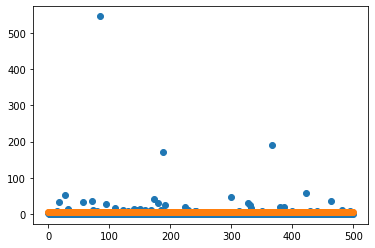

In [15]:
import matplotlib.pyplot as plt
plt.scatter(list(range(len(y_total))), y_total)
plt.scatter(list(range(len(pred_total))), pred_total)
plt.show()

In [22]:
print(pred_total)

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 